In [28]:
import numpy as np
from tqdm import tqdm
from math import sqrt,exp
import matplotlib
from matplotlib import pyplot as plt
from multiprocessing import Pool
from itertools import product
from itertools import combinations
from qutip import *
settings.num_cpus = 100
font = {'size'   : 17}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 5, 4
plt.rcParams['figure.dpi'] = 70
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = "both"

### Creating Hamiltonian manually

In [25]:
def get_basis(Ek_0):
    sing_basis = ['0u', '0d']
    for i in range(1, len(Ek_0)+1):
        sing_basis +=  [str(i)+'u', str(i)+'d']
    basis = []
    for i in range(2*len(Ek_0)+3):
        basis += combinations(sing_basis, i)
    return basis

    
    
def diag(Ek_0, V, U):
    basis = get_basis(Ek_0)
    H = np.zeros([len(basis)]*2)
    for i, state in enumerate(basis):
        if ('0u' in state and '0d' in state) or ('0u' not in state and '0d' not in state):
            H[i][i] += U/4
        else:
            H[i][i] -= U/4
        for k in range(1, len(Ek_0)+1):
            if str(k)+'u' not in state and str(k)+'d' not in state:
                H[i][i] -= Ek_0[k-1]
            elif str(k)+'u' in state and str(k)+'d' in state:
                H[i][i] += Ek_0[k-1]
    return H


def off_diag(Ek_0, V, U):
    basis = get_basis(Ek_0)
    H = np.zeros([len(basis)]*2)
    for k in range(1, len(Ek_0)+1):
        for (i, si), (j, sj) in product(enumerate(basis), enumerate(basis)):
            si = list(si)
            sj = list(sj)
            if i==j or si == () or sj == ():
                continue
            if set(si + [str(k)+'u']) == set(sj + ['0u']) or set(sj + [str(k)+'u']) == set(si + ['0u']):
                H[i][j] = V
            if set(si + [str(k)+'d']) == set(sj + ['0d']) or set(sj + [str(k)+'d']) == set(si + ['0d']):
                H[i][j] = V
    return H
        
    
def get_nd(Ek_0):
    basis = get_basis(Ek_0)
    nd_up = np.zeros([len(basis)]*2)
    nd_dn = np.zeros([len(basis)]*2)
    for i, state in enumerate(basis):
        if '0u' in state:
            nd_up [i][i] = 1
        if '0d' in state:
            nd_dn [i][i] = 1
    return nd_up, nd_dn

### Creating Hamiltonian using Qutip

In [26]:
def get_ham(Ek_0, V, ed, U):
    H_d = 0
    H_k = 0
    H_v = 0
    dim = len(Ek_0)
    numop = create(2)*destroy(2)
    cop = destroy(2)
    H_d += ed*tensor([numop, identity(2)] + [identity(2)]*2*dim)
    H_d += ed*tensor([identity(2), numop] + [identity(2)]*2*dim)
    H_d += U*tensor([numop, numop] + [identity(2)]*2*dim)
    for i in range(dim):
        rem = (dim - i - 1)
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [numop, identity(2)] + [identity(2)]*2*rem))
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [identity(2), numop] + [identity(2)]*2*rem))
        H_v += V * tensor([cop.dag(), identity(2)] + [identity(2)]*2*i + [cop, identity(2)] + [identity(2)]*2*rem)
        H_v += V * tensor([identity(2), cop.dag()] + [identity(2)]*2*i + [identity(2), cop] + [identity(2)]*2*rem)
    return H_d + H_k + H_v + H_v.dag()

### $T=0$ Spectral function

100%|██████████| 3072/3072 [00:00<00:00, 450584.06it/s]


0.8955


100%|██████████| 1024/1024 [00:00<00:00, 617093.00it/s]


0.4019


100%|██████████| 2048/2048 [00:00<00:00, 527540.05it/s]


0.1711


100%|██████████| 2048/2048 [00:00<00:00, 506481.99it/s]


0.0595


100%|██████████| 1024/1024 [00:00<00:00, 496298.51it/s]


0.0092


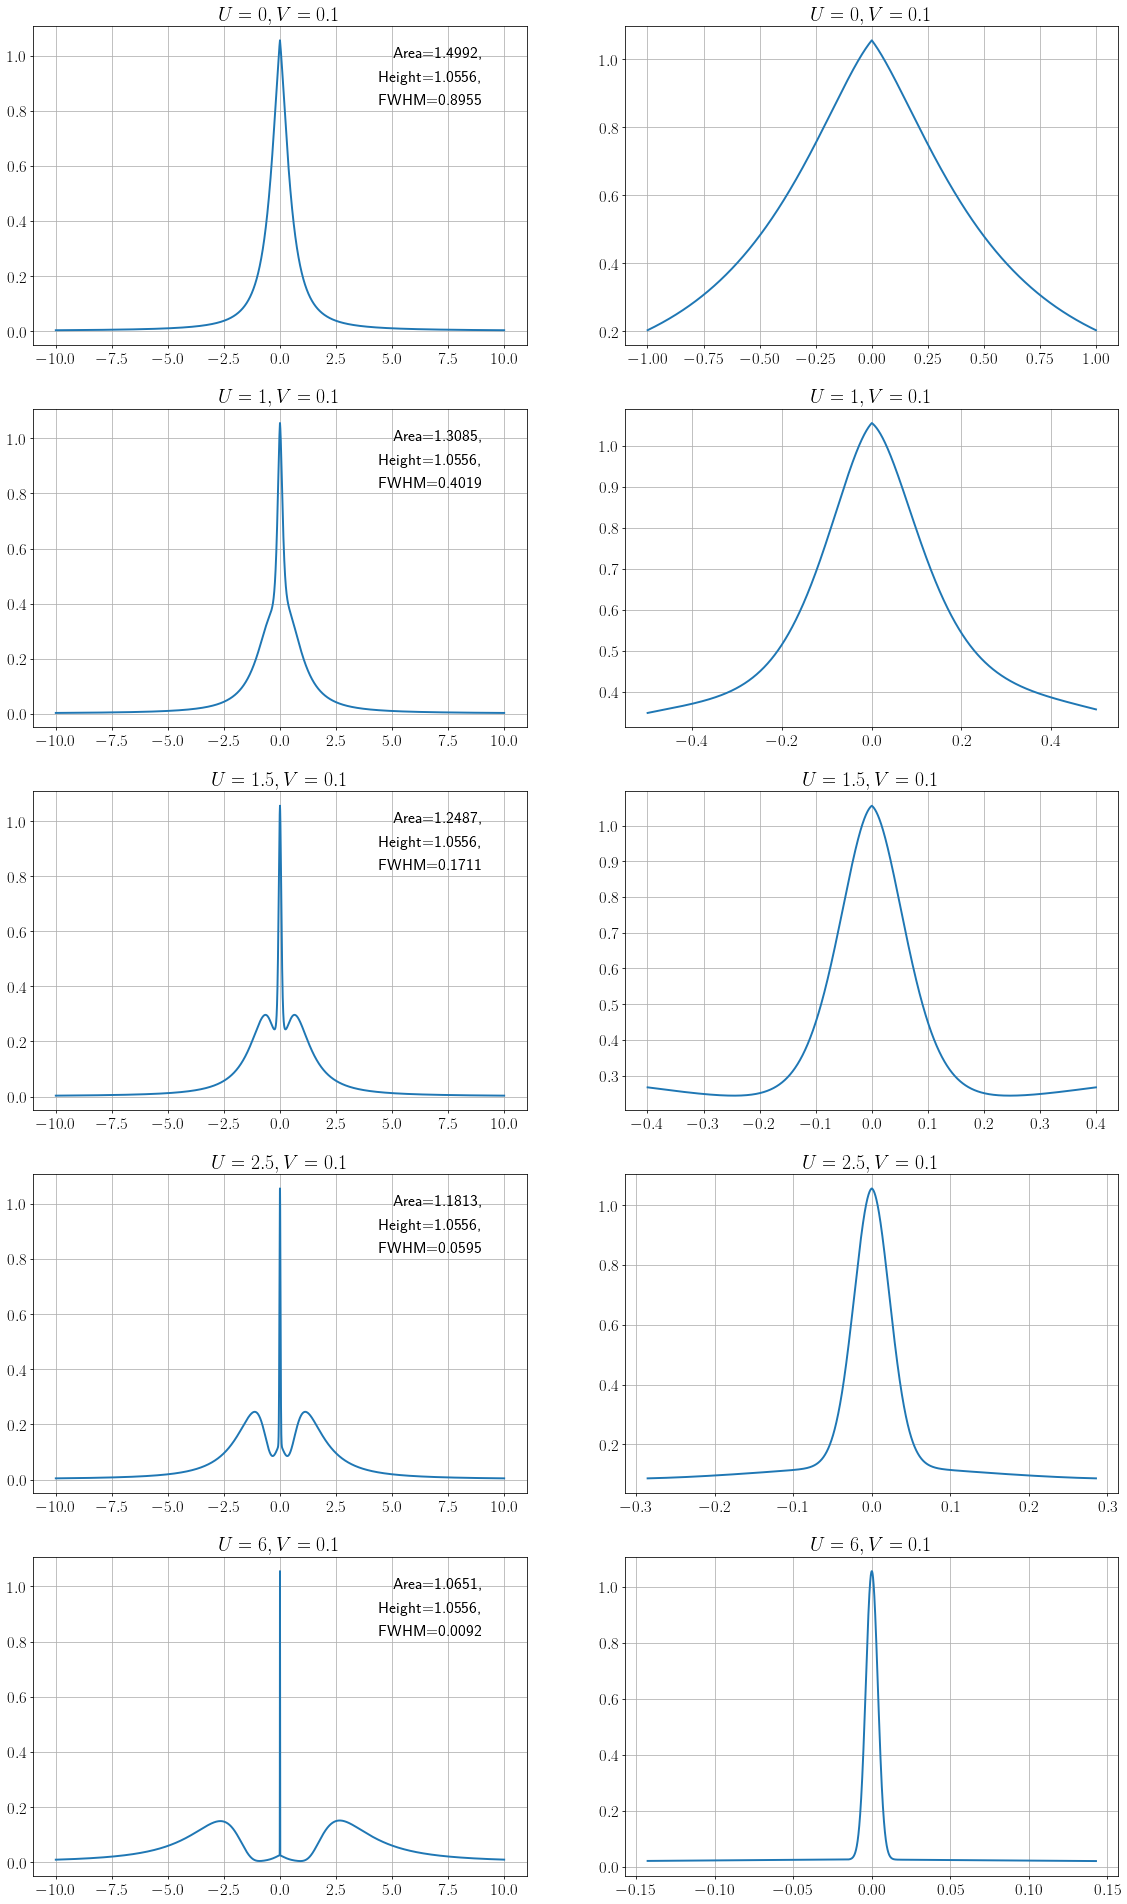

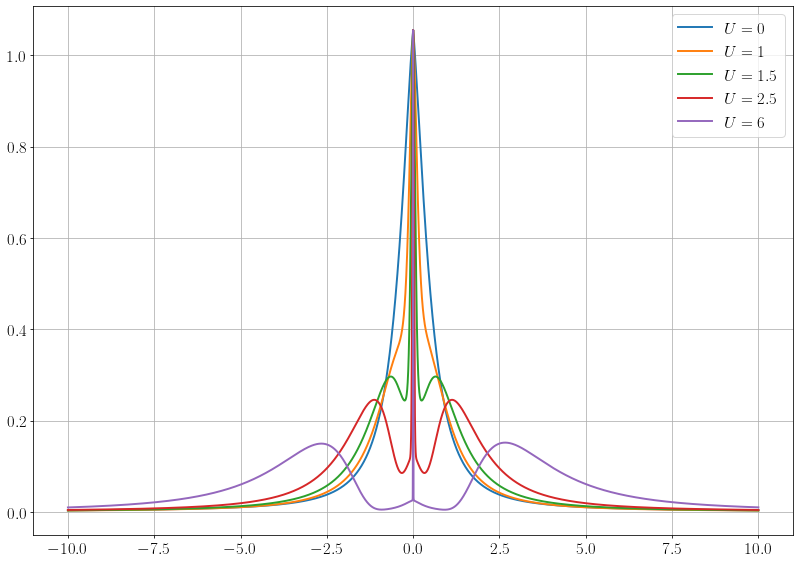

In [36]:
def get_rho_X(args):
#     h = 50
    (En, Xn), Xgs, factor, flag = args
    eta = 4*t + abs(w_range)/2
    Egs = E[0]
    c0_up = tensor([identity(2), destroy(2)] + [identity(2)]*(len(Xgs.dims[0])-2))
    C1 = Xgs.dag()*c0_up*Xn
    C1_sq = np.real((C1*C1.dag())[0][0][0])
    C2 = Xn.dag()*c0_up*Xgs
    C2_sq = np.real((C2*C2.dag())[0][0][0])
    x1 = w_range + Egs - En
    x2 = w_range + En - Egs
    if flag == True:
        return En - Egs, (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / len(X0)
    else:
        if abs(En - Egs) < w_cut and h > 0:
            eta /= factor
        return (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / len(X0)


        
def get_correction_factor(E, X, h):
    X0 = X[np.where(E == min(E))]
    A = 0
    w_ll = 0
    w_gg = 0
    for pi, Ai in list(tqdm(Pool().map(get_rho_X, product(zip(E, X), X0, [1], [True])), total=len(X0)*len(E))):
        A += Ai
        if pi < w_cut:
            w_ll += Ai[np.where(w_range == 0)]
        else:
            w_gg += Ai[np.where(w_range == 0)]
    factor = (h - w_gg)/w_ll
    return factor


def get_FWHM(w_range, A):
    w_half = w_range[(A <= max(A)) & (A>=max(A)/2)]
    return (max(w_half) - min(w_half))
    

fig1, ax1 = plt.subplots(5,2, figsize=(20,35))
fig2, ax2 = plt.subplots(figsize=(14,10))
h = 1
i = -1
ht_area = []
for U in [0, 1, 1.5, 2.5, 6]:
# for U in [0]:
    i += 1
    ed = -U/2
    V = 0.1
    t = 0.1
    Nk = 4
    a = 100
    k_bath = 2*np.pi*np.arange(0, Nk)/(a*Nk)
    Ek_0 = -2*t*np.cos(k_bath*a)
        
    w_end = 10
    len_w = 10000
    w_half = np.linspace(0, w_end, len_w)**4/w_end**3
    w_range = np.unique(np.concatenate([-w_half, w_half]))
    w_cut = 10**(-4)

    
    H = get_ham(Ek_0, V, ed, U)
    H = 0.5 * (H + H.dag())
    E, X = H.eigenstates()
    X0 = X[np.where(E == min(E))]
    if U == 0:
        A = sum(list(tqdm(Pool().map(get_rho_X, product(zip(E, X), X0, [1], [False])), total=len(X0)*len(E))))
        h = A[np.where(w_range == 0)] 
    else:
        factor = get_correction_factor(E, X, h)
        A = sum(list(tqdm(Pool().map(get_rho_X, product(zip(E, X), X0, [factor], [False])), total=len(X0)*len(E))))
        
    ax1[i][0].plot(w_range, A)
    ax1[i][0].set_title(r"$U={}, V={}$".format(U, V))
    ax1[i][1].plot(w_range[np.where(abs(w_range) < 1/(1+U))], A[np.where(abs(w_range) < 1/(1+U))])
    ax1[i][1].set_title(r"$U={}, V={}$".format(U, V))
    maxA = np.round(max(A), 4)
    area = np.round(np.trapz(A, w_range),4)
    fwhm = np.round(get_FWHM(w_range, A), 4)
    print (fwhm)
    ax1[i][0].text(0.7, 0.9, r"Area={},\\\\Height={},\\\\FWHM={}".format(area, maxA, fwhm),transform = ax1[i][0].transAxes)
    ax2.plot(w_range, A, label=r"$U={}$".format(U))

ax2.legend()
fig1.savefig("merged.pdf", bbox_inches='tight')
fig2.savefig("merged_all.pdf", bbox_inches='tight')
plt.show()